# ASMSA: Train AAE model with the tuned hyperparameters

**Previous steps**
- [prepare.ipynb](prepare.ipynb): Download and sanity check input files
- [tune.ipynb](tune.ipynb): Perform initial hyperparameter tuning for this molecule

**Next step**
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

## Notebook setup

In [1]:
#%cd villin

In [2]:
threads = 2
import os
os.environ['OMP_NUM_THREADS']=str(threads)
import tensorflow as tf

# PyTorch favours OMP_NUM_THREADS in environment
import torch

# Tensorflow needs explicit cofig calls
tf.config.threading.set_inter_op_parallelism_threads(threads)
tf.config.threading.set_intra_op_parallelism_threads(threads)

2025-04-14 12:42:04.227647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-14 12:42:04.243875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-14 12:42:04.248722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-14 12:42:04.263997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 12:42:05.029163: W tensorflow/compiler/tf2

In [3]:
from asmsa.tuning_analyzer import TuningAnalyzer
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import urllib.request
from tensorflow import keras
import keras_tuner
import asmsa.visualizer as visualizer
import asmsa


from asmsa.plot_training import LiveTrainingPlot

2025-04-14 12:42:07.082591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1182 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:61:00.0, compute capability: 8.0


## Input files

All input files are prepared (up- or downloaded) in [prepare.ipynb](prepare.ipynb). 


In [4]:
exec(open('inputs.py').read())

## Apply the tuning results

In [5]:
# pick from plots in tune.ipynb

best_enc_seed=128
best_disc_seed=32

In [6]:
# Get best HP from latest tuning
analyzer = TuningAnalyzer()
analyzer.get_best_hp(num_trials=3)

Analyzing tuning from: /home/jovyan/ASMSA/analysis/09152024-062740/
Printing results of tuning: /home/jovyan/ASMSA/analysis/09152024-062740/
-----(1)-----
Trial ID: af0a1be1bc6e6b34943556cfaaf5329e63d7a224f8e4aa892d62b941673839f3
Hyperparameters:
activation: gelu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.15383518146453173
-----(2)-----
Trial ID: abae5f92717a95f68c7f7560850cef4a5fd75cd6ff0b0639ce6bb8324bf15efa
Hyperparameters:
activation: selu
ae_number_of_layers: 2
disc_number_of_layers: 2
batch_size: 64
optimizer: Adam
learning_rate: 0.0002
ae_loss_fn: MeanSquaredError
disc_loss_fn: BinaryCrossentropy
Score: 0.18225192744528268
-----(3)-----
Trial ID: b2c0e33e1bc5ab4528251267d0f562aaabc06e4e25a736d0da8e0167833e1feb
Hyperparameters:
activation: selu
ae_number_of_layers: 2
disc_number_of_layers: 5
batch_size: 512
optimizer: Adam
learning_rate: 0.0002
ae_loss_

In [7]:
# Select HP to use by specifying trial_id
#  e.g: trial_id = '483883b929b3445bff6dee9759c4d50ee3a4ba7f0db22e665c49b5f942d9693b'
# ... or don't specify, by default use the trial with the lowest score
trial_id = 'abae5f92717a95f68c7f7560850cef4a5fd75cd6ff0b0639ce6bb8324bf15efa'

hps = None
for trial in analyzer.sorted_trials:
    if trial['trial_id'] == trial_id:
        hps = trial['hp']
    
if not hps:
    print(f'Could not find trial with specified ID, using one with the lowest score - {analyzer.sorted_trials[0]["trial_id"]}')
    hps = analyzer.sorted_trials[0]['hp']
    
print(hps)

{'activation': 'selu', 'ae_number_of_layers': 2, 'disc_number_of_layers': 2, 'batch_size': 64, 'optimizer': 'Adam', 'learning_rate': 0.0002, 'ae_loss_fn': 'MeanSquaredError', 'disc_loss_fn': 'BinaryCrossentropy'}


## Load datasets
Load filtered trajectory datasets that were processed in **prepare.ipynb**. Trajectories are in internal coordinates format.

In [8]:
# load train dataset
X_train = tf.data.Dataset.load('datasets/intcoords/train')

# get batched version of dataset to feed to AAE model for training
X_train_batched = X_train.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for visualization purposes
X_train_np = np.stack(list(X_train))
X_train_np.shape

2025-04-14 12:42:31.213678: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(34599, 1355)

In [9]:
# load test dataset
X_test = tf.data.Dataset.load('datasets/intcoords/test')

# get batched version of dataset to feed to AAE model for prediction
X_test_batched = X_test.batch(hps['batch_size'],drop_remainder=True)

# get numpy version for testing purposes
X_test_np = np.stack(list(X_test))
X_test_np.shape

2025-04-14 12:42:32.143975: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(7444, 1355)

In [10]:
X_val = tf.data.Dataset.load('datasets/intcoords/validate').batch(hps['batch_size'],drop_remainder=True)
X_val

<_BatchDataset element_spec=TensorSpec(shape=(64, 1355), dtype=tf.float32, name=None)>

## Train

### Distribution prior
Train with common prior distributions. See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions for all available distributions. It is ideal to use tuned Hyperparameters for training.

In [11]:
# set used prior

# this one is (more or less) required to with the density alignment
# prior = tfp.distributions.MultivariateNormalDiag(loc=[0.,0.])

prior = tfp.distributions.Normal(loc=0, scale=1)
# prior = tfp.distributions.Uniform()
# prior = tfp.distributions.Weibull(1,0.5)
# prior = tfp.distributions.Cauchy(loc=0, scale=1)

In [12]:
# prepare model using the best hyperparameters
testm = asmsa.AAEModel((X_train_np.shape[1],),
                       prior=prior,
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       with_density=False
                      )
testm.compile()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
testm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1355)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_0 (Dense)                   │ (None, 128)            │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_1 (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_2 (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_bn_2 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_out (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_3 (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_3 (BatchNormalization)   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_1 (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_1 (BatchNormalization)   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_0 (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_bn_0 (BatchNormalization)   │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_out (Dense)                 │ (None, 1355)           │       174,795 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1355)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,085 (1.42 MB)

 Trainable params: 370,189 (1.41 MB)

 Non-trainable params: 896 (3.50 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_0 (Dense)                  │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_0 (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_1 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_1 (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_2 (Dense)                  │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_relu_2 (LeakyReLU)         │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disc_out (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# specify earlystopping callback to avoid overfitting
#monitored_metric = "val_AE loss min"
#monitored_metric = 'val_loss'

metric_groups = {
    'Autoencoder Loss': ['AE loss min', 'val_val_AE loss min'],
    'Discriminator Loss': ['disc loss min', 'val_val_disc loss min']
}

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_val_AE loss min",
    min_delta=0.0001,
    patience=15,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

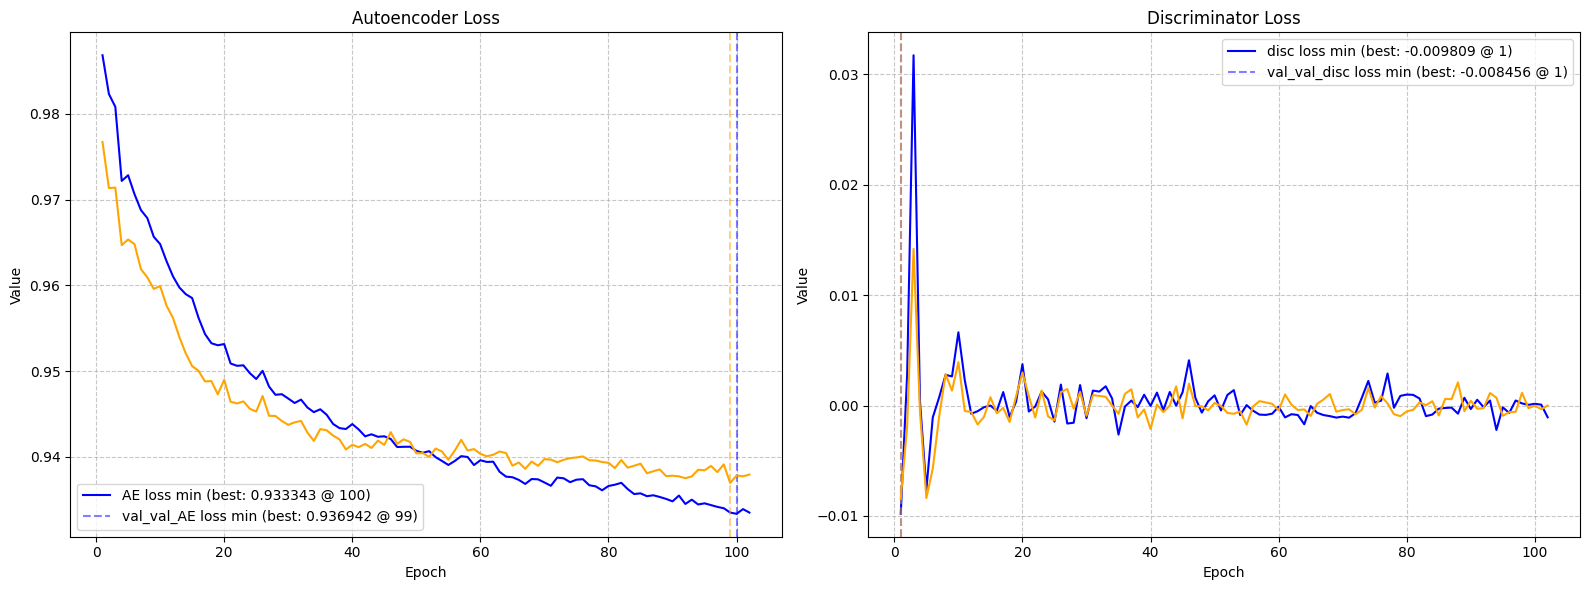

540/540 - 1s - 3ms/step - AE loss min: 0.9335 - disc loss min: -1.0625e-03 - val_val_AE loss min: 0.9379 - val_val_disc loss min: -2.6450e-06
Epoch 103/1000



KeyboardInterrupt



In [15]:
# train it (can be repeated several times to add more epochs)

testm.fit(X_train_batched, # X_train_dens, # X_train_batched,
          epochs=1000,
          verbose=2, # this flag is essential due to connection with EarlyStopping callback (epoch vs batch)
          validation_data=X_val,
          callbacks=[
              early_stop_cb,
              LiveTrainingPlot(metric_groups=metric_groups, freq=1),
              #visualizer.VisualizeCallback(testm,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

In [ ]:
# whatever test
''' 
batch_size = 256

val_result = testm.predict(X_test_batched)
mse = keras.losses.MeanSquaredError()
dataset_size = X_test_np.shape[0]
print(dataset_size)
mse_result=[]
for i in range(0, dataset_size, batch_size):
    if i+batch_size > dataset_size:
        batch_size = batch_size-(i+batch_size-dataset_size)
    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()
    mse_result.append(batch_mse)

mse_result'''

In [ ]:
# final visualization, pick a slice of the input data for demo purposes
#visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np[15000:20000]).numpy())

# on test data
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_test_np).numpy())

In [ ]:
visualizer.Visualizer(figsize=(12,3)).make_visualization(testm.call_enc(X_train_np).numpy())

In [ ]:
# load testing trajectory for further visualizations and computations
tr = md.load('x_test.xtc',top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like Ala-Ala, where superposing on CAs fails
#idx=tr[0].top.select("element != H") 

tr.superpose(tr[0],atom_indices=idx)

# reshuffle the geometry to get frame last so that we can use vectorized calculations
geom = np.moveaxis(tr.xyz ,0,-1)
geom.shape

In [ ]:
# Rgyr and rmsd color coded in low dim (rough view)

lows = testm.call_enc(X_test_np).numpy()
rg = md.compute_rg(tr)
base = md.load(conf)
rmsd = md.rmsd(tr,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

In [ ]:
# not used
'''testm.enc.save('enc.keras')
testm.dec.save('dec.keras')
testm.disc.save('dec.keras')'''

### Image prior

**Almost surely broken now with the density alignment**

Use Image as a prior distribution. Again use tuned Hyperparameters for better training performance.

In [ ]:
urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1I2WP92MMWS5s5vin_4cvmruuV-1W77Hl", "mushroom_bw.png")

In [ ]:
mmush = asmsa.AAEModel((X_train_np.shape[1],),
                       hp=hps,
                       enc_seed=best_enc_seed,
                       disc_seed=best_disc_seed,
                       prior='mushroom_bw.png'
                      )
mmush.compile()

In [ ]:
mmush.fit(X_train_batched,
          epochs=500,
          verbose=2,
          callbacks=[
              early_stop_cb,
              visualizer.VisualizeCallback(mmush,freq=25,inputs=X_train_np[15000:25000],figsize=(12,3))
          ])

In [ ]:
# - plot AE loss min during training
# - specify "since_epoch" for better plot scaling (ignore outliers)
# - note that numbering of epochs starts at 1, 0th epoch does not exist
since_epoch = 1
monitored_metric = 'AE loss min'

assert since_epoch > 0
history = np.array(mmush.history.history[monitored_metric])
y = history[since_epoch-1:]
x = list(range(since_epoch, len(y)+since_epoch))
result = np.array(list(map(lambda x: x+1, np.where(history == history.min())[0]))) # add +1 to convert index to epoch

[plt.axvline(_x, linewidth=0.5, color='r', ls=':') for _x in result]
plt.plot(x, y)
plt.title(f'Best weights for metric [{monitored_metric}] at epoch/s {result}')
plt.show()

In [ ]:
batch_size = 256

val_result = testm.predict(X_test_batched)
mse = keras.losses.MeanSquaredError()
dataset_size = X_test_np.shape[0]
print(dataset_size)
mse_result=[]
for i in range(0, dataset_size, batch_size):
    if i+batch_size > dataset_size:
        batch_size = batch_size-(i+batch_size-dataset_size)
    batch_mse = mse(X_test_np[i:i+batch_size],val_result[i:i+batch_size]).numpy()
    mse_result.append(batch_mse)

mse_result

In [ ]:
step=4
tr2 = tr[::step]
lows = mmush.call_enc(X_test_np[::step]).numpy()
rg = md.compute_rg(tr2)
base = md.load(conf)
rmsd = md.rmsd(tr2,base[0])
cmap = plt.get_cmap('rainbow')
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rg,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("Rg")
plt.subplot(122)
plt.scatter(lows[:,0],lows[:,1],marker='.',c=rmsd,cmap=cmap)
plt.colorbar(cmap=cmap)
plt.title("RMSD")
plt.show()

## Save the encoder and decoder models

In [ ]:
import tf2onnx
import onnx2torch
import tempfile

def _convert_to_onnx(model, destination_path):
#    model = keras.models.load_model(source_path)

    input_tensor = model.layers[0]._input_tensor
#    input_tensor = model.inputs[0]
    input_signature = tf.TensorSpec(
        name=input_tensor.name, shape=input_tensor.shape, dtype=input_tensor.dtype
    )
    output_name = model.layers[-1].name

    @tf.function(input_signature=[input_signature])
    def _wrapped_model(input_data):
        return {output_name: model(input_data)}

    tf2onnx.convert.from_function(
        _wrapped_model, input_signature=[input_signature], output_path=destination_path
    )

In [ ]:
model = testm

In [ ]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.enc,onnx.name)
    torch_enc = onnx2torch.convert(onnx.name)

example_input = torch.randn([X_train_np.shape[1]])
traced_script_module = torch.jit.trace(torch_enc, example_input)

traced_script_module.save('encoder.pt')

In [ ]:
example_input.shape

In [ ]:
model.enc.summary()

In [ ]:
lenc = torch.jit.load('encoder.pt')
example_input = np.random.rand(10000,X_train_np.shape[1])
rtf = model.enc(example_input)
rpt = lenc(torch.tensor(example_input,dtype=torch.float32))

In [ ]:
maxerr = np.max(np.abs(rtf - rpt.detach().numpy()))
maxerr

In [ ]:
with tempfile.NamedTemporaryFile() as onnx:
    _convert_to_onnx(model.dec,onnx.name)
    torch_dec = onnx2torch.convert(onnx.name)

example_input = torch.randn([2])
traced_script_module = torch.jit.trace(torch_dec, example_input)

traced_script_module.save('decoder.pt')

In [ ]:
ldec = torch.jit.load('decoder.pt')
example_input = np.random.rand(10000,2)
rtf = model.dec(example_input)
rpt = ldec(torch.tensor(example_input,dtype=torch.float32))

In [ ]:
err = np.abs(rtf - rpt.detach().numpy())
train_mean = np.loadtxt('datasets/intcoords/mean.txt',dtype=np.float32).reshape(1,1,-1)
rerr = err/np.abs(train_mean)
np.max(err),np.max(rerr)